#**РК2**

**Старых Фёдор Артемович, ИУ5-65Б\
Вариант 17:\
метод 1: метод опорных векторов\
метод 2: градиентный бустинг\
датасет: fifa-2018-match-statistics**

**Задание**\
Для заданного набора данных (по Вашему варианту) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (по варианту для Вашей группы). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

##**Решение**

###**Импорт библиотек и загрузка данных**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import Image
from io import StringIO 
from typing import Tuple, Dict
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.svm import LinearSVR, SVR, SVC
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer, MissingIndicator
%matplotlib inline 
sns.set(style="ticks")

In [2]:
# загрузка данных
uploaded = files.upload()

Saving Admission_Predict_Ver1.1.csv to Admission_Predict_Ver1.1.csv


In [ ]:
data = pd.read_csv('Admission_Predict_Ver1.1.csv', sep=',')

###**Характериситики датасета**

In [4]:
# размер датасета
data.shape

(500, 9)

In [5]:
# типы колонок
data.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

In [6]:
# первые 5 строк
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [7]:
# статистические характеристики признаков
data.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [8]:
# Количество пропусков в данных
data.isna().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [9]:
# Количество уникальных значений для каждого признака
data.nunique()

Serial No.           500
GRE Score             49
TOEFL Score           29
University Rating      5
SOP                    9
LOR                    9
CGPA                 184
Research               2
Chance of Admit       61
dtype: int64

###**Заполнение пропусков данных**

In [11]:
# удалим признаки Own goals и Own goals time
# т.к. почти все значения этих признаков пусты
cols_to_drop = ['Research']
data_new_1 = data.drop(cols_to_drop, axis=1)
(data.shape, data_new_1.shape)

((500, 9), (500, 8))

In [12]:
# для признака 1st Goal заполним пустые значения 0
# что будет значит, что гола не было
data_new_2 = data_new_1.fillna(0)
data_new_2.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,0.92
1,2,324,107,4,4.0,4.5,8.87,0.76
2,3,316,104,3,3.0,3.5,8.00,0.72
3,4,322,110,3,3.5,2.5,8.67,0.80
4,5,314,103,2,2.0,3.0,8.21,0.65


In [13]:
# пропусков не осталось
data_new_2.isna().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Chance of Admit      0
dtype: int64

###**Кодирование категориальных признаков**

In [14]:
# оценим важность признаков для целевого
dataLE = data_new_2.copy()
le = LabelEncoder()
col_obj = dataLE.dtypes[dataLE.dtypes==object].index.values.tolist()
for i in col_obj:
  dataLE[i] = le.fit_transform(dataLE[i])
(dataLE.corr()['University Rating']*100).sort_values(ascending=False)

University Rating    100.000000
SOP                   72.802357
CGPA                  70.525435
Chance of Admit       69.013237
TOEFL Score           64.979920
GRE Score             63.537621
LOR                   60.865071
Serial No.            -6.764057
Name: University Rating, dtype: float64

In [15]:
# по результатам корреляционного анализа удаляем столбцы,
# которые имеют меньшую значимость по отношению к целевому признаку
del_data = (dataLE.corr()['University Rating']*100).sort_values(ascending=False)
del_col = del_data[(del_data < 10) & (del_data > -10) | (del_data.isnull())].index.values.tolist()
data_new_2.drop(columns=del_col, inplace=True)
dataLE.drop(columns=del_col, inplace=True)
data_new_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 27.5 KB


In [17]:
# выполним one-hot encoding и масштабирование для применения в SVM
col_num = data_new_2.dtypes[data_new_2.dtypes!=object].index.values.tolist()
col_num.remove('University Rating')
se = StandardScaler()
data_new_2[col_num] = se.fit_transform(data_new_2[col_num])
data_new_2 = pd.get_dummies(data_new_2, drop_first=True)

In [18]:
data_new_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    float64
 1   TOEFL Score        500 non-null    float64
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Chance of Admit    500 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 27.5 KB


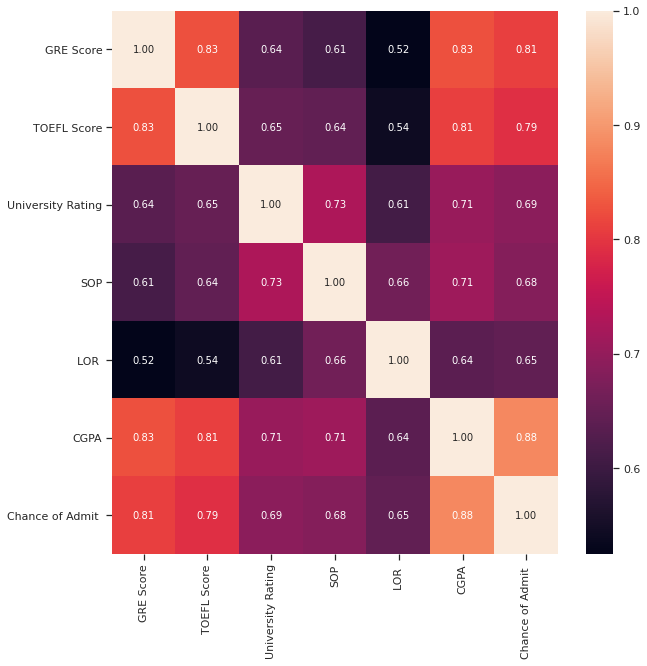

In [19]:
plt.figure(figsize=(10,10))
g = sns.heatmap(data_new_2.corr(), annot=True, fmt='.2f')

###**Разделение выборки на обучающую и тестовую**

In [20]:
# разделим данные на целевой столбец и признаки
X = data_new_2.drop("University Rating", axis=1)
Y = data_new_2["University Rating"]

In [21]:
# с использованием метода train_test_split разделим выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((375, 6), (125, 6), (375,), (125,))

###**Метод опорных векторов**

In [22]:
svr = SVR(kernel='rbf')
svr.fit(X_train, Y_train)
print("r2_score:", r2_score(Y_test, svr.predict(X_test)))
print("mean_squared_error", mean_squared_error(Y_test, svr.predict(X_test)))

r2_score: 0.5635857794845018
mean_squared_error 0.5865407123728296


###**Градиентный бустинг**

In [23]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, Y_train)
print("r2_score:", r2_score(Y_test, gbr.predict(X_test)))
print("mean_squared_error", mean_squared_error(Y_test, gbr.predict(X_test)))

r2_score: 0.5271965460867761
mean_squared_error 0.635447842059373


###**Итог**

Метод опорных векторов показал себя лучше градиентного бустинга, однако коэффициент детерминации для обеих моделей получилось меньше 50%, что говорит о плохом качестве моделей. Вероятно это связано со слабой связностью датасета.